In [ ]:
# This notebook contains experiments that are meant to show a progression of ensembling methods
# in simple settings to progressively more complex settings.
# I only focus on problems with categorical targets, and compare how they perform to comprable continuous targets.

# Checklist for experiments:
# - [x] Try a 1-layer ensemble classification problem where the targets are generated by binning a continuous variable.
#       Compare the learning curve to that of simply doing regression with and without ensembling.
# - [ ] Repeat the same as above but use HL-Gauss to generate the targets and calculate losses.
# - [ ] If these work well, try them with the 2-layer GEOFF task using only feature search.
#       Generate results for base learning network size scaling, target input scaling, and level of stochasticity.

In [4]:
from collections import defaultdict
import time
from typing import Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

from phd.feature_search.core.models import LTU, MultipleLinear, ParallelLinear
from phd.feature_search.core.idbd import IDBD

%matplotlib inline

## 1-Layer continuous -> categorical classification experiment

In [5]:
def run_1l_classification_experiment(
    n_train_samples: int,
    n_inputs: int,
    n_members: int,
    n_target_bins: int,
    step_size: float = 0.01,
    noise_std: float = 0.0,
    device: str = 'cpu',
    seed: Optional[int] = None,
):
    seed = int(time.time() * 1000) if seed is None else seed
    torch.manual_seed(seed)

    # Generate random weights for the input features
    target_model = nn.Linear(n_inputs, 1, device=device)
    
    # Generate random weights for the ensemble using ParallelLinear
    # Output should be categorical logits for each bin
    ensemble_model = ParallelLinear(
        in_features = n_inputs,
        out_features = n_target_bins,
        n_parallel = n_members,
        bias = True,
        generator = torch.Generator().manual_seed(seed + 1)
    ).to(device)
    
    # Create an RMSProp optimizer for the ensemble
    optimizer = optim.RMSprop(ensemble_model.parameters(), lr=step_size)
    
    # Generate a set of input samples
    inputs = torch.randn(n_train_samples, n_inputs, device=device)
    
    # Generate targets for each input sample with a pass through the target model using a normal distribution
    with torch.no_grad():
        continuous_targets = target_model(inputs).squeeze(-1)  # Shape: (n_train_samples,)
        # Add some noise to make it more realistic
        noise = torch.randn_like(continuous_targets) * noise_std
        continuous_targets = continuous_targets + noise
    
    # Create the bin boundaries as being uniform with the edges forming a 99% interval
    # for values sampled from a normal distribution
    target_mean = 0.0
    target_std = 1.0
    # Use 99% confidence interval
    lower_bound = target_mean - 2.576 * target_std
    upper_bound = target_mean + 2.576 * target_std
    bin_edges = torch.linspace(lower_bound, upper_bound, n_target_bins + 1, device=device)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Count targets that fall outside the bin edges (outliers)
    n_outliers = ((continuous_targets < bin_edges[0]) | 
                  (continuous_targets > bin_edges[-1])).sum().item()
    pct_outliers = 100 * n_outliers / n_train_samples
    print(f"Percentage of outlier targets: {pct_outliers:.2f}%")
    
    # Generate categorical targets by binning the continuous targets
    categorical_targets = torch.bucketize(continuous_targets, bin_edges, right=False) - 1
    # Ensure targets are within valid range [0, n_target_bins-1]
    categorical_targets = torch.clamp(categorical_targets, 0, n_target_bins - 1)
    
    # Create a dict of lists to store metrics
    metrics = {
        'mean_ensemble_loss': [],
        'continuous_loss': [],
        'categorical_accuracy': [],
        'prediction_entropy': [], # Added entropy metric
        'cumulative_accuracies': [], # Added cumulative accuracy metric
    }
    
    # For each sample:
    for i in range(n_train_samples):
        # Get the step's input and output
        input_sample = inputs[i:i+1]  # Shape: (1, n_inputs)
        cat_target = categorical_targets[i:i+1]  # Shape: (1,)
        cont_target = continuous_targets[i:i+1]  # Shape: (1,)
        
        # Forward pass through ensemble
        ensemble_outputs = ensemble_model(input_sample)  # Shape: (1, n_members, n_target_bins)
        
        # Each ensemble member should be trained independently on the categorical target
        # Calculate cross-entropy loss for each member
        # Shape: (1, n_members, n_target_bins) -> (n_members, n_target_bins)
        member_logits = ensemble_outputs.squeeze(0)
        # Expand targets to match each member
        expanded_targets = cat_target.expand(n_members)
        # Calculate loss for all members at once
        cat_loss = F.cross_entropy(member_logits, expanded_targets, reduction='sum')
        
        # Calculate ensemble predictions for majority voting
        # Get predictions from each member and collate with majority vote
        member_predictions = torch.argmax(ensemble_outputs, dim=2).squeeze(0)  # Shape: (1, n_members)
        ensemble_cat_pred = torch.mode(member_predictions).values  # Shape: (,)
        
        # Train on the one step with RMSProp
        optimizer.zero_grad()
        cat_loss.backward()
        optimizer.step()
        
        # Log the loss and the loss when converting the prediction back to a continuous variable
        with torch.no_grad():
            # Calculate accuracy for categorical prediction using majority vote
            cat_accuracy = (ensemble_cat_pred == cat_target.squeeze()).float().mean().item()
            
            # Calculate MSE for continuous prediction
            ensemble_cont_pred = bin_centers[ensemble_cat_pred]  # Shape: (,)
            cont_loss = F.mse_loss(ensemble_cont_pred, cont_target.squeeze()).item()
            
            # Calculate entropy of member predictions
            pred_counts = torch.bincount(member_predictions, minlength=n_target_bins)
            pred_probs = pred_counts.float() / n_members
            entropy = -torch.sum(pred_probs * torch.log(pred_probs + 1e-10)).item()
            
            # Calculate cumulative accuracies using first n members
            cumulative_accuracies = []
            for n in range(1, n_members + 1):
                # Get predictions from first n members
                partial_preds = member_predictions[:n]
                # Get majority vote from these members
                partial_pred = torch.mode(partial_preds).values
                # Calculate accuracy
                partial_accuracy = (partial_pred == cat_target.squeeze()).float().item()
                cumulative_accuracies.append(partial_accuracy)
            
            metrics['mean_ensemble_loss'].append(cat_loss.item() / n_members)
            metrics['continuous_loss'].append(cont_loss)
            metrics['categorical_accuracy'].append(cat_accuracy)
            metrics['prediction_entropy'].append(entropy)
            metrics['cumulative_accuracies'].append(cumulative_accuracies)
    
    # Return a tuple that contains the ensemble model, target model, loss, and dict of metrics
    return ensemble_model, target_model, metrics

In [6]:
learning_model, target_model, metrics = run_1l_classification_experiment(
    n_train_samples = 2000,
    n_inputs = 10,
    n_members = 20,
    n_target_bins = 20,
    step_size = 0.01,
    noise_std = 0.0,
    device = 'cpu',
    seed = 542,
)

Percentage of outlier targets: 0.05%


KeyboardInterrupt: 

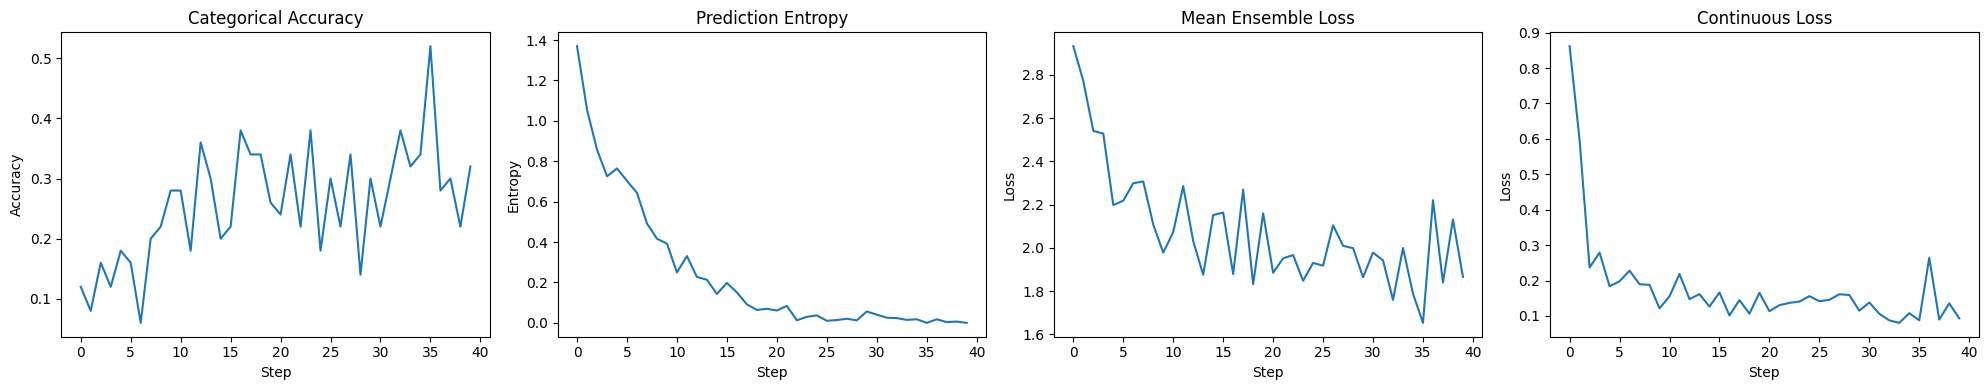

In [ ]:
bin_size = 50

# Convert to numpy array and reshape into groups of bin_size
acc_array = np.array(metrics['categorical_accuracy'])
n_bins = len(acc_array) // bin_size
acc_binned = acc_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

ent_array = np.array(metrics['prediction_entropy'])
ent_binned = ent_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

loss_array = np.array(metrics['mean_ensemble_loss'])
loss_binned = loss_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

cont_array = np.array(metrics['continuous_loss'])
cont_binned = cont_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

# Plot the smoothed metrics
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))

sns.lineplot(data=acc_binned, ax=ax1)
ax1.set_title('Categorical Accuracy')
ax1.set_xlabel('Step')
ax1.set_ylabel('Accuracy')

sns.lineplot(data=ent_binned, ax=ax2)
ax2.set_title('Prediction Entropy') 
ax2.set_xlabel('Step')
ax2.set_ylabel('Entropy')

sns.lineplot(data=loss_binned, ax=ax3)
ax3.set_title('Mean Ensemble Loss')
ax3.set_xlabel('Step')
ax3.set_ylabel('Loss')

sns.lineplot(data=cont_binned, ax=ax4)
ax4.set_title('Continuous Loss')
ax4.set_xlabel('Step')
ax4.set_ylabel('Loss')

plt.tight_layout()

## 2-Layer classification experiment

In [7]:
# Experiment steps:
# 1. Make a 2-layer target model with binary input weights, kaiming uniform output weights, and an LTU activation.
# 2. Create a set of input samples
# 3. Compute continuous valued targets by passing inputs through the target model.
# 4. Normalize the targets.
# 5. Create bins based on the 99% edges of the targets.
# 6. Create categorical targets based on the bins.
# 7. Make a learning ensemble with an LTU activation, kaiming uniform output weights, and an
#    FTA output activation that converts the continuous output to a categorical output.
# 8. Set the inputs weights for each of the ensembles to be equal to the true network input weights
#    a given percentage of the time.
# 9. Freeze the input layers of the learning ensembles.
# 10. For each sample, get a prediction from the ensembles, and update each ensemble based on the
#     cross entropy between its prediction and the category of the target network.
# 11. Log the accuracy when taking the bin with the highest density across all ensembles.

# Simplified experiment steps:
# 1. Make a 2-layer target model with binary input weights, kaiming uniform output weights, an LTU activation,
#    and a categorical, argmax output. (If it's a sample based output, then I would expect it to learn the distribution produced)
# 2. Create a set of input samples
# 3. Make a learning ensemble with an LTU activation, kaiming uniform output weights, and categorical
#    logits outputs.
# 4. Set the inputs weights for each of the ensembles to be equal to the true network input weights
#    a given percentage of the time.
# 5. Freeze the input layers of the learning ensembles.
# 6. For each sample, get a prediction from the ensembles, and update each ensemble based on the
#     cross entropy between its prediction and the category of the target network.
# 7. Log the accuracy when taking the bin with the highest density across all ensembles.

In [28]:
def run_2l_classification_experiment(
    n_train_samples: int,
    n_inputs: int,
    n_hidden_units: int,
    n_members: int,
    n_target_bins: int,
    weight_correct_frac_bounds: Tuple[float, float] = (0.0, 1.0),
    step_size: float = 0.01,
    noise_std: float = 0.0,
    replay_iters_per_step: int = 0,
    replay_batch_size: int = 16,
    device: str = 'cpu',
    seed: Optional[int] = None,
):
    seed = int(time.time() * 1000) if seed is None else seed
    torch.manual_seed(seed)
    
    ### Generate inputs ###
    
    inputs = torch.randn(n_train_samples, n_inputs, device=device)

    ### Init target model ###

    target_model = nn.Sequential(
        nn.Linear(n_inputs, n_hidden_units, device=device, bias=False),
        LTU(),
        nn.Linear(n_hidden_units, n_target_bins, device=device, bias=False),
    )
    
    target_input_layer = target_model[0]
    target_input_layer.weight.data = torch.randint(
        0, 2, target_input_layer.weight.shape, device=target_input_layer.weight.device,
        generator=torch.Generator(device=device).manual_seed(seed + 1),
    ).float() * 2 - 1
    
    ### Compute target values ###
    
    with torch.no_grad():
        target_logits = target_model(inputs)  # Shape: (n_train_samples, n_target_bins)
        if noise_std > 0.0:
            noise = torch.randn_like(target_logits) * noise_std
            target_logits += noise
        target_labels = torch.argmax(target_logits, dim=-1)  # Shape: (n_train_samples,)
    
    ### Init learning model ###
    
    ensemble_model = nn.Sequential(
        ParallelLinear(
            in_features = n_inputs,
            out_features = n_hidden_units,
            n_parallel = n_members,
            bias = False,
        ),
        LTU(),
        MultipleLinear(
            in_features = n_hidden_units,
            out_features = n_target_bins,
            n_parallel = n_members,
            bias = False,
            generator = torch.Generator().manual_seed(seed + 2)
        ),
    ).to(device)
    
    ### Set the first layer to partially correct values, then freeze it ###

    n_input_weights = n_inputs * n_hidden_units
    correct_frac = np.random.uniform(*weight_correct_frac_bounds)
    # correct_frac += (1.0 / n_input_weights) / 2.0 # Round to nearest possible value
    n_correct = int(n_input_weights * correct_frac)
    n_incorrect = n_input_weights - n_correct
    
    ideal_weights = target_input_layer.weight.data.clone()
    new_input_weights = ideal_weights.repeat(n_members, 1, 1) # Size: (n_members, n_hidden_units, n_inputs)
    for i in range(n_members):
        incorrect_idxs = np.random.choice(n_inputs * n_hidden_units, size=n_incorrect, replace=False)
        incorrect_idxs = np.unravel_index(incorrect_idxs, (n_hidden_units, n_inputs))
        new_input_weights[i, incorrect_idxs[0], incorrect_idxs[1]] = -new_input_weights[i, incorrect_idxs[0], incorrect_idxs[1]]
    
    ensemble_model[0].weight.data = new_input_weights.reshape(*ensemble_model[0].weight.shape)
    ensemble_model[0].weight.requires_grad = False
    
    # Create an Adam optimizer for the ensemble
    optimizer = optim.SGD(ensemble_model.parameters(), lr=step_size)
    # optimizer = IDBD(
    #     ensemble_model.parameters(),
    #     meta_lr = 0.005,
    #     init_lr = step_size,
    #     autostep = True,
    # )
    
    # Create a dict of lists to store metrics
    metrics = {
        'mean_ensemble_loss': [],
        'categorical_accuracy': [],
        'prediction_entropy': [], # Added entropy metric
    }
    
    # For each sample:
    for i in range(n_train_samples):
        for _ in range(replay_iters_per_step):
            if i == 0:
                continue
            
            # 1. Randomly sample from inputs[:i] to get a batch of size replay_batch_size
            replay_idxs = np.random.choice(i, size=min(i, replay_batch_size), replace=False)
            replay_inputs = inputs[replay_idxs]
            replay_targets = target_labels[replay_idxs]
            
            # 2. Forward pass through ensemble
            ensemble_outputs = ensemble_model(replay_inputs)
            cat_loss = F.cross_entropy(
                ensemble_outputs.permute(0, 2, 1),
                replay_targets.unsqueeze(1).expand(replay_targets.shape[0], n_members),
                reduction='none',
            )
            cat_loss = cat_loss.sum(dim=1).mean()
            optimizer.zero_grad()
            cat_loss.backward()
            optimizer.step()
        
        # Get the step's input and output
        input_sample = inputs[i:i+1]  # Shape: (1, n_inputs)
        target_label = target_labels[i:i+1]  # Shape: (1,)
        
        # Forward pass through ensemble
        ensemble_outputs = ensemble_model(input_sample)  # Shape: (1, n_members, n_target_bins)
        
        # Each ensemble member should be trained independently on the categorical target
        # Calculate cross-entropy loss for each member
        cat_loss = F.cross_entropy(ensemble_outputs.squeeze(0), target_label.expand(n_members), reduction='sum')
        
        pred_probs = F.softmax(ensemble_outputs.squeeze(0), dim=-1)
        # cat_loss = torch.sum(-torch.log(pred_probs[:, target_label.squeeze()]))
        
        # Calculate ensemble predictions for majority voting
        # Get predictions from each member and collate with majority vote
        member_predictions = torch.argmax(ensemble_outputs, dim=2)  # Shape: (1, n_members)
        ensemble_cat_pred = torch.mode(member_predictions.squeeze(0)).values  # Shape: (,)
        # ensemble_cat_pred = ensemble_outputs.squeeze(0).sum(dim=0).argmax()
        
        # print(ensemble_cat_pred)
    
        # Train on the one step with RMSProp
        optimizer.zero_grad()
        cat_loss.backward()
        optimizer.step()
        
        # Log the loss and the loss when converting the prediction back to a continuous variable
        with torch.no_grad():
            # Calculate accuracy for categorical prediction using majority vote
            cat_accuracy = (ensemble_cat_pred == target_label.squeeze()).float().mean().item()
            
            # Calculate entropy of member predictions
            pred_counts = torch.bincount(member_predictions.squeeze(0), minlength=n_target_bins)
            pred_probs = pred_counts.float() / n_members
            entropy = -torch.sum(pred_probs * torch.log(pred_probs + 1e-10)).item()
            
            metrics['mean_ensemble_loss'].append(cat_loss.item() / n_members)
            metrics['categorical_accuracy'].append(cat_accuracy)
            metrics['prediction_entropy'].append(entropy)
    
    # Return a tuple that contains the ensemble model, target model, loss, and dict of metrics
    return ensemble_model, target_model, metrics

In [26]:
def plot_metrics(metrics, bin_size=200):
    """Plot smoothed training metrics.
    
    Args:
        metrics: Dictionary containing 'categorical_accuracy', 'prediction_entropy', 
                and 'mean_ensemble_loss' arrays
        bin_size: Size of bins for smoothing the curves
    """
    # Convert to numpy array and reshape into groups of bin_size
    acc_array = np.array(metrics['categorical_accuracy'])
    n_bins = len(acc_array) // bin_size
    acc_binned = acc_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

    ent_array = np.array(metrics['prediction_entropy'])
    ent_binned = ent_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

    loss_array = np.array(metrics['mean_ensemble_loss'])
    loss_binned = loss_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

    # Plot the smoothed metrics
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

    sns.lineplot(data=acc_binned, ax=ax1)
    ax1.set_title('Categorical Accuracy')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Accuracy')

    sns.lineplot(data=ent_binned, ax=ax2)
    ax2.set_title('Prediction Entropy') 
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Entropy')

    sns.lineplot(data=loss_binned, ax=ax3)
    ax3.set_title('Mean Ensemble Loss')
    ax3.set_xlabel('Step')
    ax3.set_ylabel('Loss')

    plt.tight_layout()

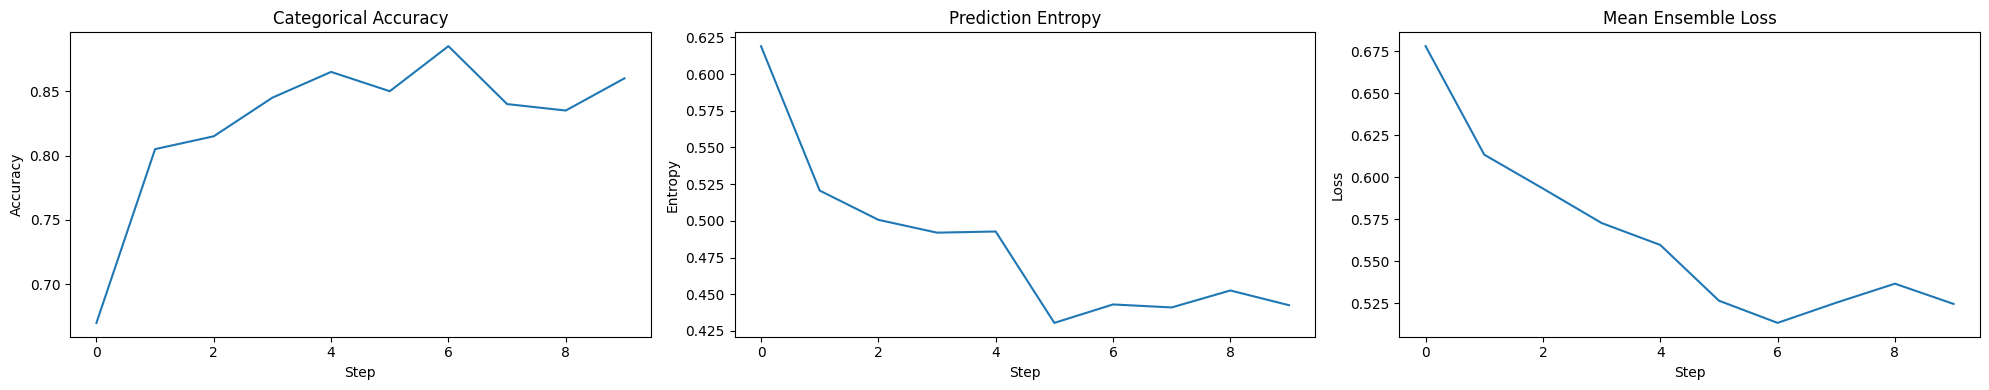

In [271]:
ensemble_model, target_model, metrics = run_2l_classification_experiment(
    n_train_samples = 2000,
    n_inputs = 10,
    n_hidden_units = 10,
    n_members = 20,
    n_target_bins = 2,
    weight_correct_frac_bounds = (0.75, 0.75),
    step_size = 0.01,
    noise_std = 0.0,
    device = 'cpu',
    seed = 9,
)

plot_metrics(metrics)

In [231]:
inputs = torch.randn(10000, 2, device='cpu')
target_logits = target_model(inputs)  # Shape: (n_train_samples, n_target_bins)
target_labels = torch.argmax(target_logits, dim=-1)  # Shape: (n_train_samples,)
target_labels.float().mean()

tensor(1.)

In [232]:
ensemble_model[0](inputs)

tensor([[[-0.8597, -0.8597, -1.9437],
         [-0.8597,  1.9437, -0.8597],
         [ 0.8597,  1.9437,  0.8597],
         ...,
         [-0.8597,  1.9437, -0.8597],
         [ 1.9437,  1.9437,  1.9437],
         [-1.9437,  0.8597,  0.8597]],

        [[-2.7039, -2.7039, -1.6475],
         [-2.7039,  1.6475, -2.7039],
         [ 2.7039,  1.6475,  2.7039],
         ...,
         [-2.7039,  1.6475, -2.7039],
         [ 1.6475,  1.6475,  1.6475],
         [-1.6475,  2.7039,  2.7039]],

        [[-2.1902, -2.1902,  0.1682],
         [-2.1902, -0.1682, -2.1902],
         [ 2.1902, -0.1682,  2.1902],
         ...,
         [-2.1902, -0.1682, -2.1902],
         [-0.1682, -0.1682, -0.1682],
         [ 0.1682,  2.1902,  2.1902]],

        ...,

        [[ 0.6290,  0.6290, -0.0225],
         [ 0.6290,  0.0225,  0.6290],
         [-0.6290,  0.0225, -0.6290],
         ...,
         [ 0.6290,  0.0225,  0.6290],
         [ 0.0225,  0.0225,  0.0225],
         [-0.0225, -0.6290, -0.6290]],

        [[

In [242]:
inputs = torch.randn(1, 2, device='cpu')

target_logits = target_model(inputs)  # Shape: (n_train_samples, n_target_bins)
target_labels = torch.argmax(target_logits, dim=-1)  # Shape: (n_train_samples,)

with torch.no_grad():
    features = ensemble_model[0](inputs).squeeze(0)
    predictions = ensemble_model(inputs).squeeze(0)  # Shape: (n_members, n_target_bins)

print('input:', inputs)
print('target features:', target_model[0](inputs))
print('target logits:', target_logits)
print('target:', target_labels.item())
print()
for i in range(predictions.shape[0]):
    print(f'logits:', predictions[i], '| features:', features[i], '| argmax:', torch.argmax(predictions[i]).item())


input: tensor([[0.9148, 0.7800]])
target features: tensor([[ 1.6948, -0.1349, -1.6948]], grad_fn=<MmBackward0>)
target logits: tensor([[-0.1440,  0.4499]], grad_fn=<MmBackward0>)
target: 1

logits: tensor([-2.9634,  2.5078]) | features: tensor([1.6948, 1.6948, 0.1349]) | argmax: 1
logits: tensor([-2.1368,  1.0676]) | features: tensor([ 1.6948, -0.1349,  1.6948]) | argmax: 1
logits: tensor([0., 0.]) | features: tensor([-1.6948, -0.1349, -1.6948]) | argmax: 0
logits: tensor([0., 0.]) | features: tensor([-0.1349, -1.6948, -1.6948]) | argmax: 0
logits: tensor([-1.1531,  2.0242]) | features: tensor([ 1.6948, -0.1349,  1.6948]) | argmax: 1
logits: tensor([-2.3376,  1.6974]) | features: tensor([ 0.1349,  1.6948, -1.6948]) | argmax: 1
logits: tensor([0., 0.]) | features: tensor([-0.1349, -0.1349, -0.1349]) | argmax: 0
logits: tensor([-0.9756,  1.4656]) | features: tensor([-0.1349,  1.6948, -1.6948]) | argmax: 1
logits: tensor([0., 0.]) | features: tensor([-1.6948, -0.1349, -1.6948]) | argmax: 

In [ ]:
# It happens when one of the target features has both weights the same
# and the other features has different weights

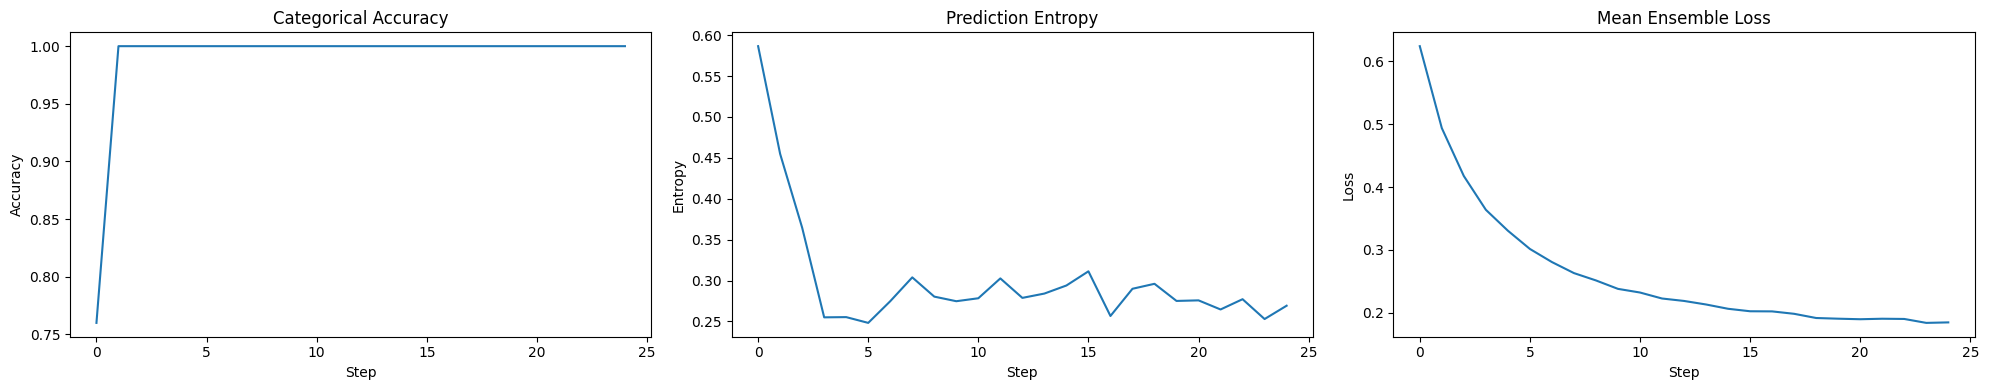

In [5]:
ensemble_model, target_model, metrics = run_2l_classification_experiment(
    n_train_samples = 5000,
    n_inputs = 2,
    n_hidden_units = 2,
    n_members = 100,
    n_target_bins = 2,
    input_weight_correct_fraction = 0.75,
    step_size = 0.003,
    noise_std = 0.0,
    device = 'cpu',
    seed = 3,
)

plot_metrics(metrics)

## Ensembling vs. Experience Replay

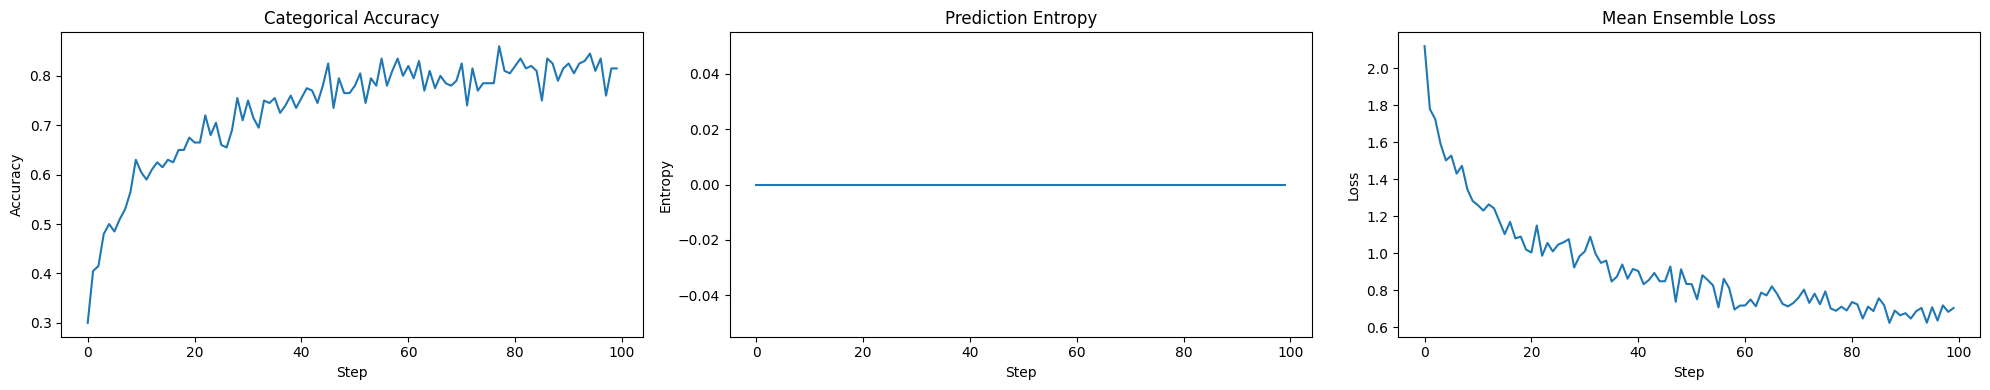

In [ ]:
# No ensembles, no replay, and perfect weights
ensemble_model, target_model, metrics = run_2l_classification_experiment(
    n_train_samples = 20_000,
    n_inputs = 20,
    n_hidden_units = 30,
    n_members = 1,
    n_target_bins = 10,
    weight_correct_frac_bounds = (1.0, 1.0),
    step_size = 0.003,
    noise_std = 0.0,
    replay_iters_per_step = 0,
    device = 'cpu',
    seed = 20250805,
)
plot_metrics(metrics)

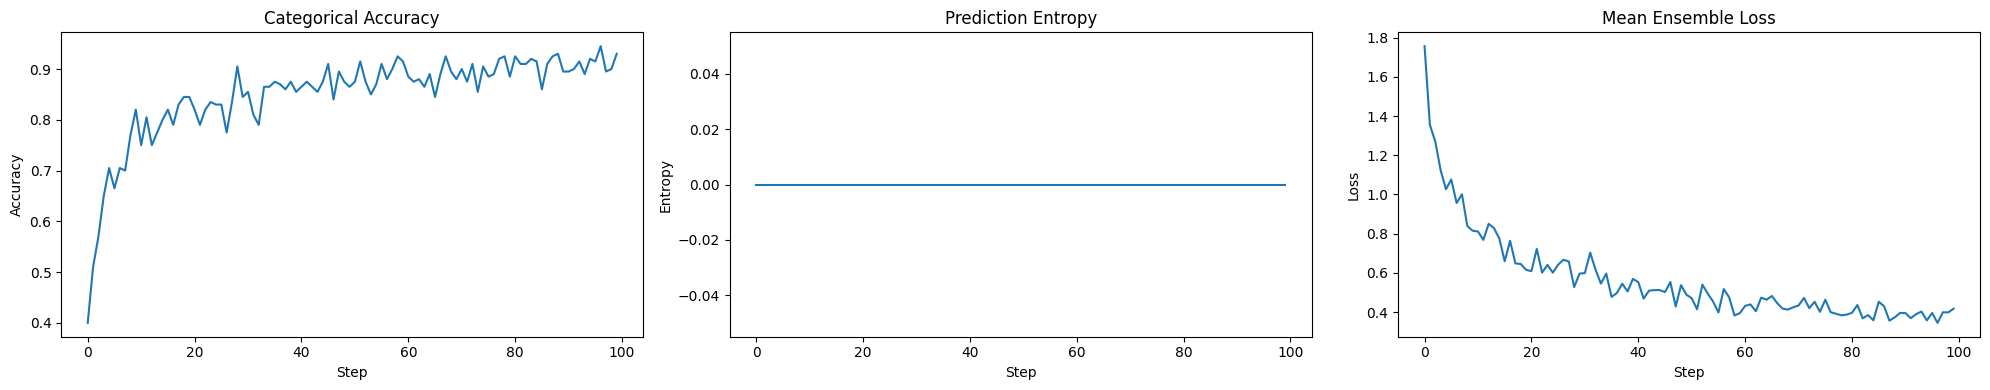

In [49]:
# No ensembles, replay, and perfect weights
ensemble_model, target_model, metrics = run_2l_classification_experiment(
    n_train_samples = 20_000,
    n_inputs = 20,
    n_hidden_units = 30,
    n_members = 1,
    n_target_bins = 10,
    weight_correct_frac_bounds = (1.0, 1.0),
    step_size = 0.003,
    noise_std = 0.0,
    replay_iters_per_step = 4,
    replay_batch_size = 8,
    device = 'cpu',
    seed = 20250805,
)
plot_metrics(metrics)

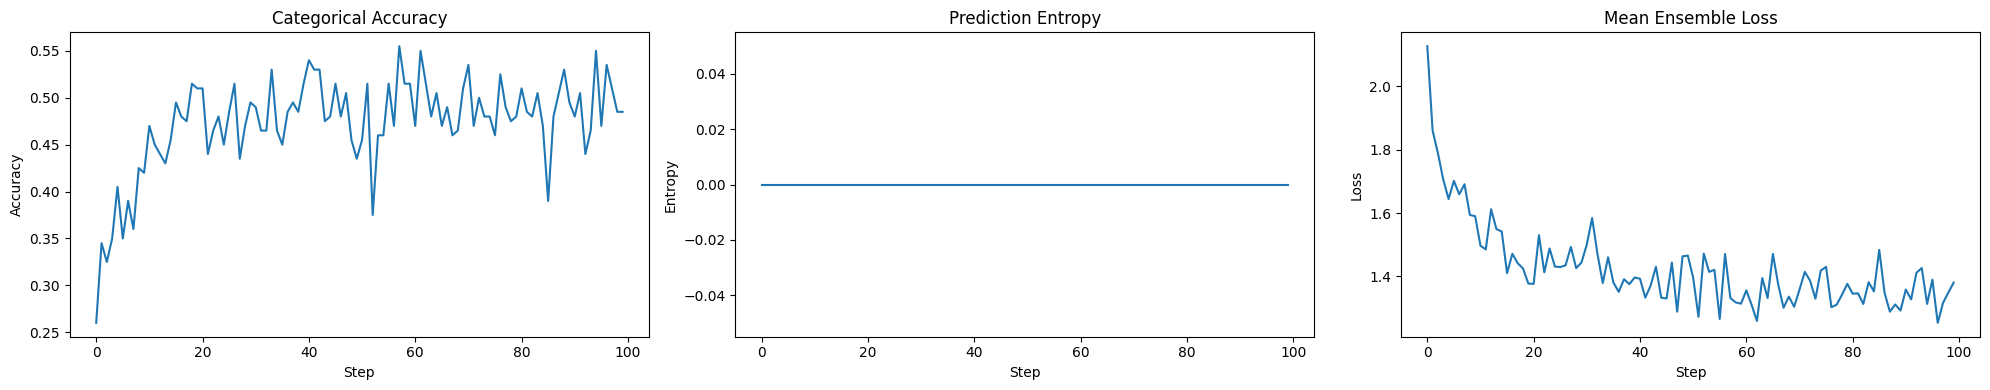

In [ ]:
# No ensembles, no replay, and imperfect weights
ensemble_model, target_model, metrics = run_2l_classification_experiment(
    n_train_samples = 20_000,
    n_inputs = 20,
    n_hidden_units = 30,
    n_members = 1,
    n_target_bins = 10,
    weight_correct_frac_bounds = (0.75, 0.75),
    step_size = 0.003,
    noise_std = 0.0,
    replay_iters_per_step = 0,
    device = 'cpu',
    seed = 20250805,
)
plot_metrics(metrics)
print('Mean accuracy: ', np.mean(metrics['categorical_accuracy']))

Mean accuracy:  0.5547


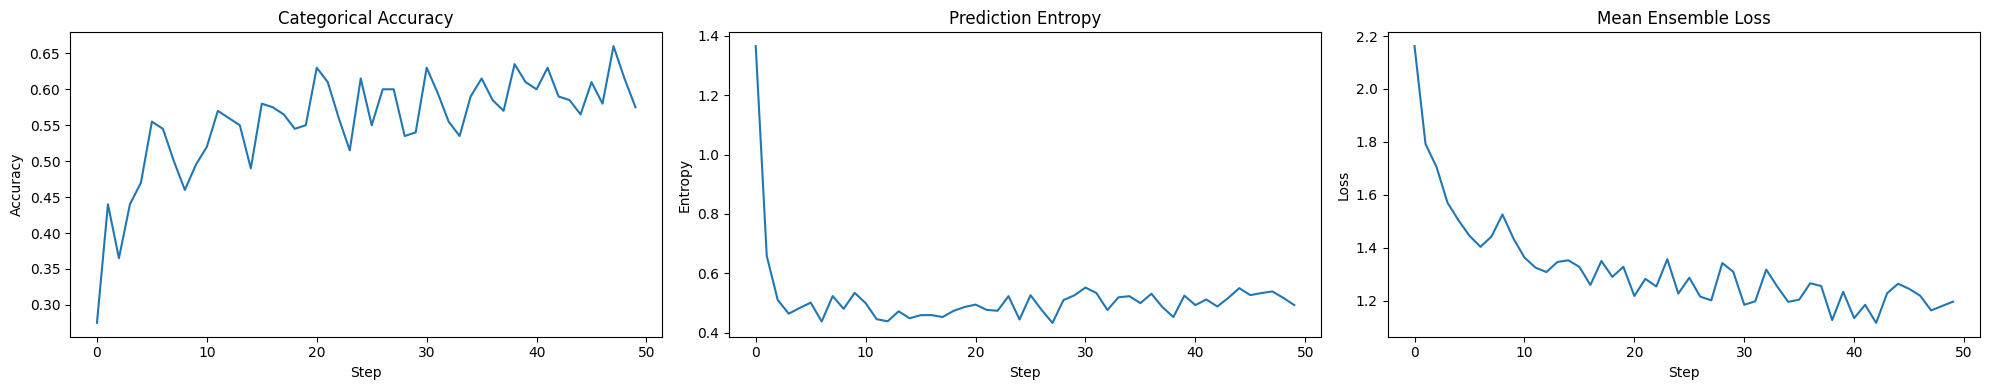

In [60]:
# Ensembles, no replay, and imperfect weights
ensemble_model, target_model, metrics = run_2l_classification_experiment(
    n_train_samples = 10_000,
    n_inputs = 20,
    n_hidden_units = 30,
    n_members = 10,
    n_target_bins = 10,
    weight_correct_frac_bounds = (0.75, 0.75),
    step_size = 0.003,
    noise_std = 0.0,
    replay_iters_per_step = 0,
    device = 'cpu',
    seed = 20250805,
)
plot_metrics(metrics)
print('Mean accuracy: ', np.mean(metrics['categorical_accuracy']))

In [ ]:
# Ensembles, replay, and imperfect weights
ensemble_model, target_model, metrics = run_2l_classification_experiment(
    n_train_samples = 10_000,
    n_inputs = 20,
    n_hidden_units = 30,
    n_members = 10,
    n_target_bins = 10,
    weight_correct_frac_bounds = (0.75, 0.75),
    step_size = 0.003,
    noise_std = 0.0,
    replay_iters_per_step = 8,
    replay_batch_size = 8,
    device = 'cpu',
    seed = 20250805,
)
plot_metrics(metrics)
print('Mean accuracy: ', np.mean(metrics['categorical_accuracy']))

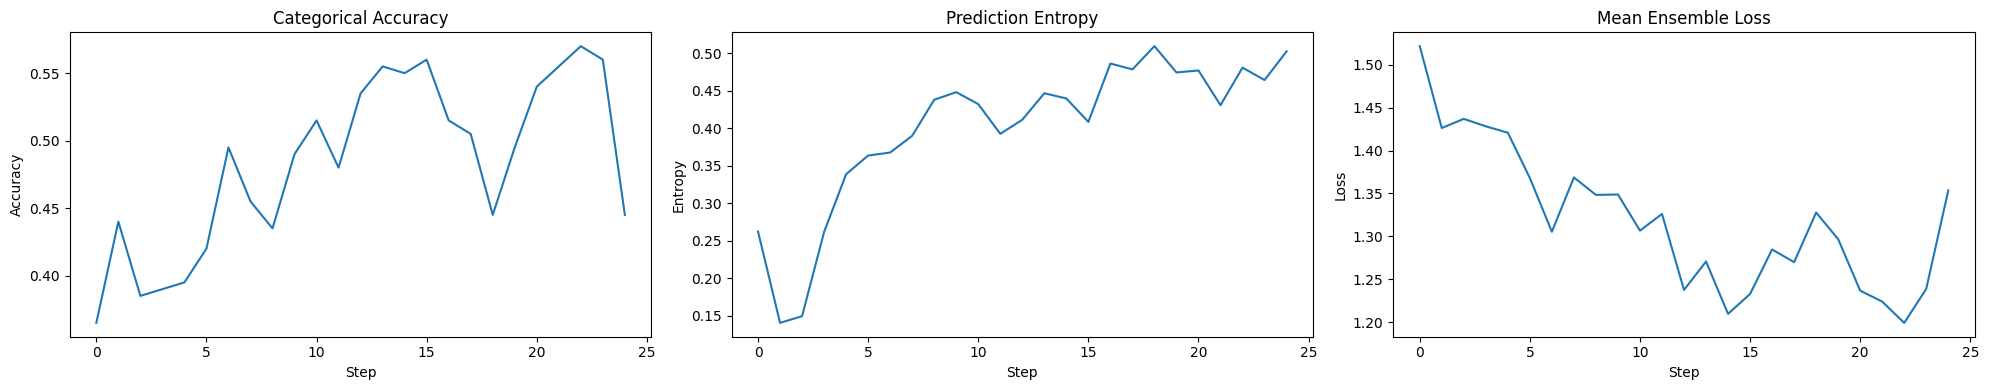

In [30]:
plot_metrics(metrics)

### Simple sweep

In [75]:
seeds = [1, 2, 3]
n_members = [1, 5, 20, 100]

all_metrics = defaultdict(list) # {n_members: [(seed, metrics), ...]}

n_runs = len(seeds) * len(n_members)

bar = tqdm(total=n_runs)
for seed in seeds:
    for n_member in n_members:
        ensemble_model, target_model, metrics = run_2l_classification_experiment(
            n_train_samples = 15_000,
            n_inputs = 20,
            n_hidden_units = 20,
            n_members = n_member,
            n_target_bins = 5,
            input_weight_correct_fraction = 0.75,
            step_size = 0.003,
            noise_std = 0.0,
            device = 'cuda' if n_member >= 20 else 'cpu',
            seed = seed,
        )
        all_metrics[n_member].append((seed, metrics))
        bar.update(1)
        
bar.close()

100%|██████████| 12/12 [09:12<00:00, 46.04s/it]


In [72]:
def plot_ensemble_comparison(all_metrics, bin_size=200):
    """
    Plot mean, min, and max metrics across seeds for each n_member value.
    
    Args:
        all_metrics: dict with structure {n_members: [(seed, metrics), ...]}
        bin_size: size of bins for smoothing the curves
    """
    
    # Get the metric names from the first run
    first_metrics = list(all_metrics.values())[0][0][1]
    metric_names = list(first_metrics.keys())
    
    # Create subplots for each metric
    n_metrics = len(metric_names)
    fig, axes = plt.subplots(1, n_metrics, figsize=(5*n_metrics, 4))
    if n_metrics == 1:
        axes = [axes]
    
    # Colors for different n_member values
    colors = plt.cm.Set1(np.linspace(0, 1, len(all_metrics)))
    
    for metric_idx, metric_name in enumerate(metric_names):
        ax = axes[metric_idx]
        
        for member_idx, (n_members, runs) in enumerate(all_metrics.items()):
            # Collect all runs for this n_members value
            all_runs_data = []
            
            for seed, metrics in runs:
                # Get the metric data for this run
                metric_data = np.array(metrics[metric_name])
                
                # Bin the data
                n_bins = len(metric_data) // bin_size
                if n_bins > 0:
                    binned_data = metric_data[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)
                    all_runs_data.append(binned_data)
            
            if all_runs_data:
                # Stack all runs for this n_members value
                stacked_data = np.array(all_runs_data)  # Shape: (n_seeds, n_bins)
                
                # Calculate mean, min, max across seeds
                mean_data = np.mean(stacked_data, axis=0)
                min_data = np.min(stacked_data, axis=0)
                max_data = np.max(stacked_data, axis=0)
                
                # Create x-axis values
                x_values = np.arange(len(mean_data)) * bin_size
                
                # Plot with shaded area for min/max bounds
                ax.plot(x_values, mean_data, 
                       label=f'n_members={n_members}', 
                       color=colors[member_idx],
                       linewidth=2)
                ax.fill_between(x_values, min_data, max_data, 
                                alpha=0.3, color=colors[member_idx])
        
        ax.set_title(f'{metric_name.replace("_", " ").title()}')
        ax.set_xlabel('Step')
        ax.set_ylabel(metric_name.replace("_", " ").title())
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

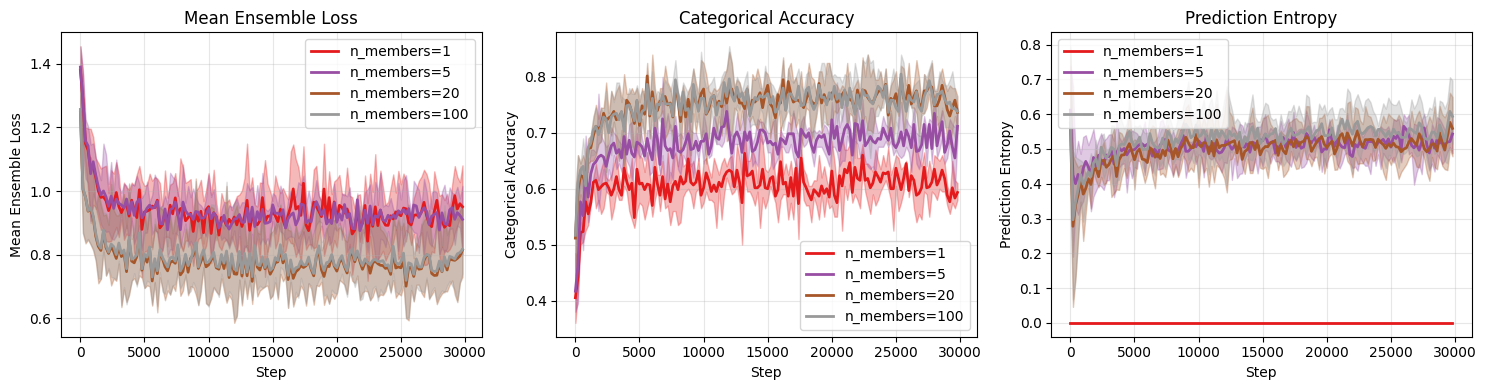

In [ ]:
# I think more ensembles doesn't improve that much because the structure of the network for
# getting the right features is already given

fig = plot_ensemble_comparison(all_metrics, bin_size=200)
plt.show()

In [ ]:
# TODO: Consider if the network actually has enough data to reach 100% accuracy
#       Could do this by maybe training the network repeatedly on the same 15k steps,
#       then evaling on test set.
#       I could also just train a model with perfect weights and compare to that.
#       I really just need to thing, can a model with a large number of ensembles that
#       on average has the right weights to just as good as a single model that has all
#       the right weights?
#       Also, is this really what I want to test? Does having the shape of the network
#       with the right activations and everything not what I want to find with this?

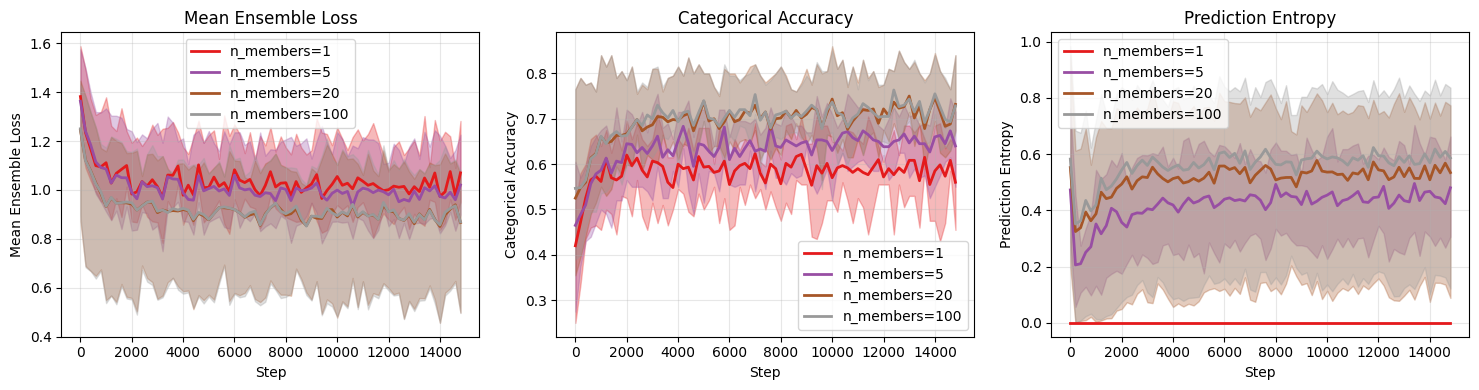

In [76]:
# I think more ensembles doesn't improve that much because the structure of the network for
# getting the right features is already given

fig = plot_ensemble_comparison(all_metrics, bin_size=200)
plt.show()

## 2-Layer continuous -> categorical classification experiment

In [ ]:
# Ensembling did not help in the previous line of experiments because the members were not diverse.
# This is inevitable when working with linear learning models.
# Next I will move on to something more similar to the 2-layer GEOFF problems I've been working with,
# but I will force the features generated to be different by manually setting the weights for the first layer.

In [3]:
# Source: https://github.com/hwang-ua/fta_pytorch_implementation/blob/main/core/lta.py
class FTA(nn.Module):
    def __init__(self, input_dim, tiles=20, bound_low=-2, bound_high=2, eta=0.2):
        super(FTA, self).__init__()
        # 1 tiling, binning
        self.n_tilings = 1
        self.n_tiles = tiles
        self.bound_low, self.bound_high = bound_low, bound_high
        self.delta = (self.bound_high - self.bound_low) / self.n_tiles
        c_mat = torch.as_tensor(np.array([self.delta * i for i in range(self.n_tiles)]) \
            + self.bound_low, dtype=torch.float32)
        self.register_buffer('c_mat', c_mat)
        self.eta = eta
        self.d = input_dim

    def forward(self, reps):
        temp = reps
        temp = temp.reshape([-1, self.d, 1])
        onehots = 1.0 - self.i_plus_eta(self.sum_relu(self.c_mat, temp))
        out = torch.reshape(torch.reshape(onehots, [-1]), [-1, int(self.d * self.n_tiles * self.n_tilings)])
        return out

    def sum_relu(self, c, x):
        out = F.relu(c - x) + F.relu(x - self.delta - c)
        return out

    def i_plus_eta(self, x):
        if self.eta == 0:
            return torch.sign(x)
        out = (x <= self.eta).type(torch.float32) * x + (x > self.eta).type(torch.float32)
        return out


In [ ]:
# Experiment steps:
# 1. Make a 2-layer target model with binary input weights, kaiming uniform output weights, and an LTU activation.
# 2. Create a set of input samples
# 3. Compute continuous valued targets by passing inputs through the target model.
# 4. Normalize the targets.
# 5. Create bins based on the 99% edges of the targets.
# 6. Create categorical targets based on the bins.
# 7. Make a learning ensemble with an LTU activation, kaiming uniform output weights, and an
#    FTA output activation that converts the continuous output to a categorical output.
# 8. Set the inputs weights for each of the ensembles to be equal to the true network input weights
#    a given percentage of the time.
# 9. Freeze the input layers of the learning ensembles.
# 10. For each sample, get a prediction from the ensembles, and update each ensemble based on the
#     cross entropy between its prediction and the category of the target network.
# 11. Log the accuracy when taking the bin with the highest density across all ensembles.

In [ ]:
def run_2l_classification_experiment(
    n_train_samples: int,
    n_inputs: int,
    n_hidden_units: int,
    n_members: int,
    n_target_bins: int,
    input_weight_correct_fraction: float = 0.5,
    step_size: float = 0.01,
    noise_std: float = 0.0,
    device: str = 'cpu',
    seed: Optional[int] = None,
):
    seed = int(time.time() * 1000) if seed is None else seed
    torch.manual_seed(seed)
    
    ### Generate inputs ###
    
    inputs = torch.randn(n_train_samples, n_inputs, device=device)

    ### Init target model ###

    target_model = nn.Sequential(
        nn.Linear(n_inputs, n_hidden_units, device=device, bias=False),
        LTU(),
        nn.Linear(n_hidden_units, 1, device=device, bias=False),
    )
    
    target_input_layer = target_model[0]
    target_input_layer.weight.data = torch.randint(
        0, 2, target_input_layer.weight.shape, device=target_input_layer.weight.device,
        generator=torch.Generator(device=device).manual_seed(seed + 1),
    ).float() * 2 - 1
    
    ### Compute target values ###
    
    with torch.no_grad():
        continuous_targets = target_model(inputs).squeeze(-1)  # Shape: (n_train_samples,)
        noise = torch.randn_like(continuous_targets) * noise_std
        continuous_targets = continuous_targets + noise
        continuous_targets -= continuous_targets.mean()
        continuous_targets /= continuous_targets.std()
    
    target_mean = continuous_targets.mean()
    target_std = continuous_targets.std()
    lower_bound = target_mean - 2.576 * target_std # Use 99% confidence interval
    upper_bound = target_mean + 2.576 * target_std
    bin_edges = torch.linspace(lower_bound, upper_bound, n_target_bins + 1, device=device)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    categorical_targets = torch.bucketize(continuous_targets, bin_edges, right=False) - 1
    categorical_targets = torch.clamp(categorical_targets, 0, n_target_bins - 1)
    
    n_outliers = ((continuous_targets < bin_edges[0]) | 
                  (continuous_targets > bin_edges[-1])).sum().item()
    pct_outliers = 100 * n_outliers / n_train_samples
    print(f"Percentage of outlier targets: {pct_outliers:.2f}%")
    
    ### Init learning model ###
    
    ensemble_model = nn.Sequential(
        ParallelLinear(
            in_features = n_inputs,
            out_features = n_hidden_units,
            n_parallel = n_members,
            bias = False,
        ),
        LTU(),
        MultipleLinear(
            in_features = n_hidden_units,
            out_features = 1,
            n_parallel = n_members,
            bias = True,
            generator = torch.Generator().manual_seed(seed + 2)
        ),
        nn.Flatten(),
        FTA(
            input_dim = n_members,
            tiles = n_target_bins,
            bound_low = lower_bound,
            bound_high = upper_bound,
            eta = 0.2,
        ),
    ).to(device)
    
    ### Set the first layer to partially correct values, then freeze it ###

    n_incorrect = int(n_inputs * n_hidden_units * (1 - input_weight_correct_fraction))
    ideal_weights = target_input_layer.weight.data.clone()
    new_input_weights = ideal_weights.repeat(n_members, 1, 1) # Size: (n_members, n_hidden_units, n_inputs)
    for i in range(n_members):
        incorrect_idxs = np.random.choice(n_inputs * n_hidden_units, size=n_incorrect, replace=False)
        incorrect_idxs = np.unravel_index(incorrect_idxs, (n_hidden_units, n_inputs))
        new_input_weights[i, incorrect_idxs[0], incorrect_idxs[1]] = -new_input_weights[i, incorrect_idxs[0], incorrect_idxs[1]]
    
    ensemble_model[0].weight.data = new_input_weights.reshape(*ensemble_model[0].weight.shape)
    ensemble_model[0].weight.requires_grad = False
    
    # Create an RMSProp optimizer for the ensemble
    optimizer = optim.RMSprop(ensemble_model.parameters(), lr=step_size)
    
    # Create a dict of lists to store metrics
    metrics = {
        'mean_ensemble_loss': [],
        'continuous_loss': [],
        'categorical_accuracy': [],
        'prediction_entropy': [], # Added entropy metric
    }
    
    # For each sample:
    for i in range(n_train_samples):
        # Get the step's input and output
        input_sample = inputs[i:i+1]  # Shape: (1, n_inputs)
        cat_target = categorical_targets[i:i+1]  # Shape: (1,)
        cont_target = continuous_targets[i:i+1]  # Shape: (1,)
        
        # Forward pass through ensemble
        ensemble_outputs = ensemble_model(input_sample)  # Shape: (1, n_members * n_target_bins)
        ensemble_outputs = ensemble_outputs.reshape(1, n_members, n_target_bins)
        
        # Each ensemble member should be trained independently on the categorical target
        # Calculate cross-entropy loss for each member
        # Shape: (1, n_members, n_target_bins) -> (n_members, n_target_bins)
        member_logits = ensemble_outputs.squeeze(0)
        # Expand targets to match each member
        expanded_targets = cat_target.expand(n_members)
        # Calculate loss for all members at once
        cat_loss = F.cross_entropy(member_logits, expanded_targets, reduction='sum')
        # print(member_logits, expanded_targets)
        # print(F.cross_entropy(member_logits, expanded_targets, reduction='none'))
        
        # Calculate ensemble predictions for majority voting
        # Get predictions from each member and collate with majority vote
        # print(ensemble_outputs.squeeze(0).sum(dim=0))
        ensemble_cat_pred = ensemble_outputs.squeeze(0).sum(dim=0).argmax()
        # ensemble_cat_pred = torch.mode(member_predictions.squeeze(0)).values  # Shape: (,)
        
        # print(ensemble_cat_pred)
    
        # Train on the one step with RMSProp
        optimizer.zero_grad()
        cat_loss.backward()
        optimizer.step()
        
        # Log the loss and the loss when converting the prediction back to a continuous variable
        with torch.no_grad():
            # Calculate accuracy for categorical prediction using majority vote
            cat_accuracy = (ensemble_cat_pred == cat_target.squeeze()).float().mean().item()
            
            # Calculate MSE for continuous prediction
            ensemble_cont_pred = bin_centers[ensemble_cat_pred]  # Shape: (,)
            cont_loss = F.mse_loss(ensemble_cont_pred, cont_target.squeeze()).item()
            
            # Calculate entropy of member predictions
            member_predictions = torch.argmax(ensemble_outputs, dim=2)  # Shape: (1, n_members)
            pred_counts = torch.bincount(member_predictions.squeeze(), minlength=n_target_bins)
            pred_probs = pred_counts.float() / n_members
            entropy = -torch.sum(pred_probs * torch.log(pred_probs + 1e-10)).item()
            
            metrics['mean_ensemble_loss'].append(cat_loss.item() / n_members)
            metrics['continuous_loss'].append(cont_loss)
            metrics['categorical_accuracy'].append(cat_accuracy)
            metrics['prediction_entropy'].append(entropy)
    
    # Return a tuple that contains the ensemble model, target model, loss, and dict of metrics
    return ensemble_model, target_model, metrics

In [294]:
learning_model, target_model, metrics = run_2l_classification_experiment(
    n_train_samples = 20000,
    n_inputs = 20,
    n_hidden_units = 20,
    n_members = 20,
    n_target_bins = 20,
    input_weight_correct_fraction = 0.9,
    step_size = 0.003,
    noise_std = 0.0,
    device = 'cpu',
    seed = 1,
)

Percentage of outlier targets: 0.81%


KeyboardInterrupt: 

In [ ]:
# This gives clean learning:
learning_model, target_model, metrics = run_2l_classification_experiment(
    n_train_samples = 10000,
    n_inputs = 20,
    n_hidden_units = 20,
    n_members = 2,
    n_target_bins = 20,
    input_weight_correct_fraction = 1.0,
    step_size = 0.003,
    noise_std = 0.0,
    device = 'cpu',
    seed = 1,
)

In [305]:
learning_model, target_model, metrics = run_2l_classification_experiment(
    n_train_samples = 10000,
    n_inputs = 20,
    n_hidden_units = 20,
    n_members = 2,
    n_target_bins = 20,
    input_weight_correct_fraction = 0.95,
    step_size = 0.003,
    noise_std = 0.0,
    device = 'cpu',
    seed = 1,
)

Percentage of outlier targets: 0.78%


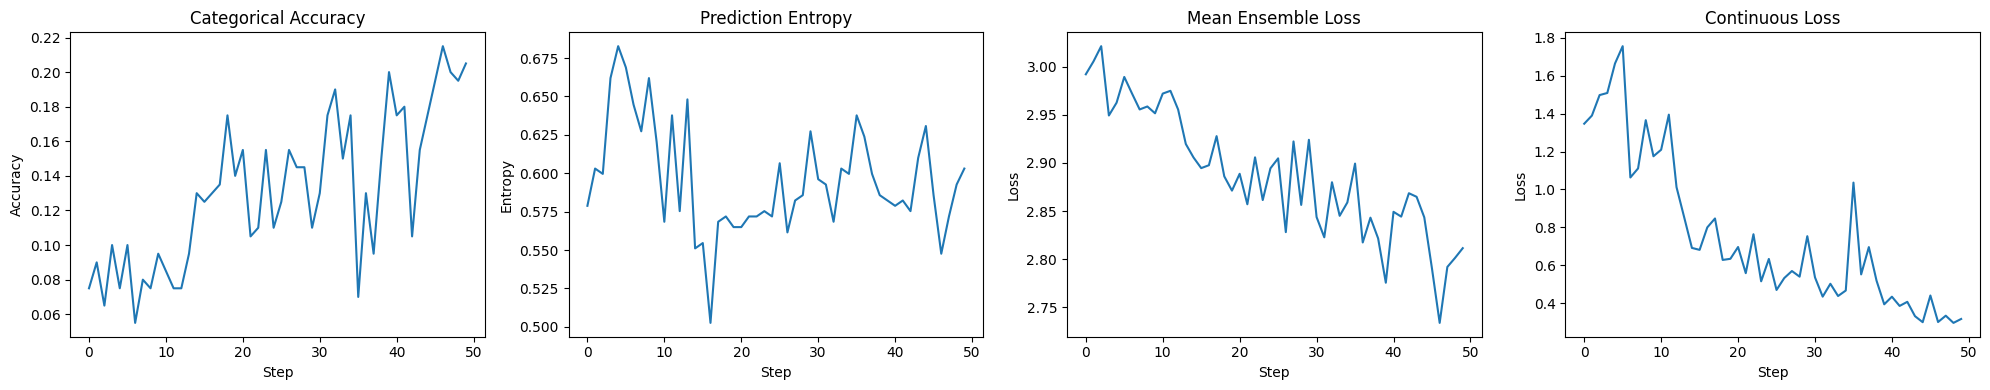

In [306]:
bin_size = 200

# Convert to numpy array and reshape into groups of bin_size
acc_array = np.array(metrics['categorical_accuracy'])
n_bins = len(acc_array) // bin_size
acc_binned = acc_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

ent_array = np.array(metrics['prediction_entropy'])
ent_binned = ent_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

loss_array = np.array(metrics['mean_ensemble_loss'])
loss_binned = loss_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

cont_array = np.array(metrics['continuous_loss'])
cont_binned = cont_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

# Plot the smoothed metrics
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))

sns.lineplot(data=acc_binned, ax=ax1)
ax1.set_title('Categorical Accuracy')
ax1.set_xlabel('Step')
ax1.set_ylabel('Accuracy')

sns.lineplot(data=ent_binned, ax=ax2)
ax2.set_title('Prediction Entropy') 
ax2.set_xlabel('Step')
ax2.set_ylabel('Entropy')

sns.lineplot(data=loss_binned, ax=ax3)
ax3.set_title('Mean Ensemble Loss')
ax3.set_xlabel('Step')
ax3.set_ylabel('Loss')

sns.lineplot(data=cont_binned, ax=ax4)
ax4.set_title('Continuous Loss')
ax4.set_xlabel('Step')
ax4.set_ylabel('Loss')

plt.tight_layout()

In [307]:
learning_model, target_model, metrics = run_2l_classification_experiment(
    n_train_samples = 10000,
    n_inputs = 20,
    n_hidden_units = 20,
    n_members = 200,
    n_target_bins = 20,
    input_weight_correct_fraction = 0.95,
    step_size = 0.003,
    noise_std = 0.0,
    device = 'cuda',
    seed = 1,
)

Percentage of outlier targets: 0.67%


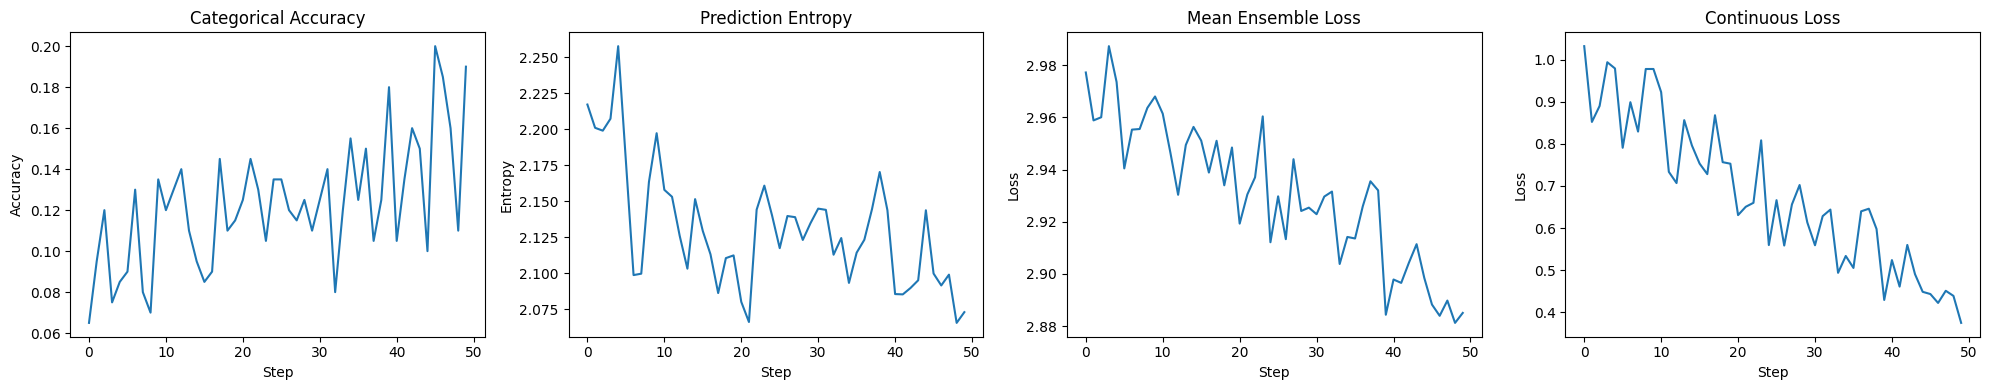

In [308]:
bin_size = 200

# Convert to numpy array and reshape into groups of bin_size
acc_array = np.array(metrics['categorical_accuracy'])
n_bins = len(acc_array) // bin_size
acc_binned = acc_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

ent_array = np.array(metrics['prediction_entropy'])
ent_binned = ent_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

loss_array = np.array(metrics['mean_ensemble_loss'])
loss_binned = loss_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

cont_array = np.array(metrics['continuous_loss'])
cont_binned = cont_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

# Plot the smoothed metrics
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))

sns.lineplot(data=acc_binned, ax=ax1)
ax1.set_title('Categorical Accuracy')
ax1.set_xlabel('Step')
ax1.set_ylabel('Accuracy')

sns.lineplot(data=ent_binned, ax=ax2)
ax2.set_title('Prediction Entropy') 
ax2.set_xlabel('Step')
ax2.set_ylabel('Entropy')

sns.lineplot(data=loss_binned, ax=ax3)
ax3.set_title('Mean Ensemble Loss')
ax3.set_xlabel('Step')
ax3.set_ylabel('Loss')

sns.lineplot(data=cont_binned, ax=ax4)
ax4.set_title('Continuous Loss')
ax4.set_xlabel('Step')
ax4.set_ylabel('Loss')

plt.tight_layout()

In [112]:
target_model[0].weight

Parameter containing:
tensor([[ 1.,  1.,  1.],
        [ 1., -1.,  1.],
        [ 1., -1., -1.],
        [ 1., -1.,  1.],
        [ 1., -1., -1.]], requires_grad=True)

In [113]:
learning_model[0].weight

Parameter containing:
tensor([[[-1.,  1., -1.],
         [ 1., -1., -1.],
         [ 1.,  1., -1.],
         [-1.,  1.,  1.],
         [-1., -1., -1.]],

        [[-1.,  1.,  1.],
         [-1.,  1., -1.],
         [-1., -1., -1.],
         [ 1., -1.,  1.],
         [-1.,  1., -1.]],

        [[ 1., -1., -1.],
         [ 1., -1., -1.],
         [ 1., -1., -1.],
         [ 1.,  1., -1.],
         [ 1.,  1.,  1.]],

        [[-1., -1.,  1.],
         [ 1., -1.,  1.],
         [ 1., -1., -1.],
         [ 1.,  1., -1.],
         [-1.,  1.,  1.]],

        [[ 1., -1., -1.],
         [ 1., -1., -1.],
         [-1.,  1., -1.],
         [ 1., -1.,  1.],
         [-1.,  1., -1.]]])